# Geographical Arbitrage for Liquified Natural Gas (LNG) Exports from the US
### Introduction
In the LNG market, arbitrage can be defined as a strategy of diverting a physical cargo from one market to another which offers a higher price. Price differentials can occur between regional markets due to different pricing structures and imbalances between supply and demand which allows traders to exploit and capitalize on. In this example, we look at the key variable costs to determine if the arbitrage window to Asia is open or if it is more profitable to ship a cargo from the United States to Asia than to Europe

In [1]:
import datetime as dt
import refinitiv.dataplatform as rdp
import pandas as pd
import requests
import matplotlib.pyplot as plt
import configparser

CONFIGURATION_FILE = "config.ini"

try:
    print("Read configuration from file")
    config = configparser.ConfigParser()
    config.read(CONFIGURATION_FILE)

    rdp_app_key = config["RDP"]["app_key"]
    rdms_app_key = config["RDMS"]["app_key"]
    rdms_url = config["RDMS"]["api"]

except Exception as e:
    print(
        f"""Error message : {e}
        Cannot get credentials from file, please create the credentials file as 'config.ini' with the format below, 
            [RDP]
            app_key = YOUR_RDP_APP_KEY
            [RDMS]
            api = YOUR_RDMS_INSTANCE_URL
            app_key = YOUR_RDMS_APP_KEY"""
    )

Read configuration from file


In [2]:
rdp.open_desktop_session(rdp_app_key)

In [3]:
start = "2019-08-01"
end = dt.datetime.today()

# The price of the gas from the pipeline
## NYMEX Henry Hub Natural Gas Electronic Energy Future Continuation 1
df = rdp.get_historical_price_summaries('NGc1',
                                         fields = ['SETTLE'],
                                         interval = rdp.Intervals.WEEKLY,
                                         start=start, end=end)
df.rename(columns={'SETTLE':'NGc1'}, inplace=True)

# Price of LNG in Asia
## Liquefied Natural Gas Asia DES Weekly Assessment
df1 = rdp.get_historical_price_summaries(
    "LNG-AS", fields=["MID_PRICE"], interval=rdp.Intervals.WEEKLY, start=start, end=end
)
df1.rename(columns={"MID_PRICE": "LNG-AS"}, inplace=True)
df = df.merge(df1, how="outer", left_index=True, right_index=True)

# Price of LNG in Netherlands
## Endex NL Netherlands TTF Natural Gas MMBTU Monthly Continuation 1
df2 = rdp.get_historical_price_summaries(
    "TFMBUSMBTMc1",
    fields=["TRDPRC_1"],
    interval=rdp.Intervals.WEEKLY,
    start=start,
    end=end,
)
df2.rename(columns={"TRDPRC_1": "TFMBUSMBTMc1"}, inplace=True)
df = df.merge(df2, how="outer", left_index=True, right_index=True)

# Price of LNG in United Kingdom
## ICE GB (Great Britain) NBP Natural Gas MMBTU Monthly Continuation 1
df3 = rdp.get_historical_price_summaries(
    "NGLNUSMBTMc1",
    fields=["TRDPRC_1"],
    interval=rdp.Intervals.WEEKLY,
    start=start,
    end=end,
)
df3.rename(columns={"TRDPRC_1": "NGLNUSMBTMc1"}, inplace=True)
df = df.merge(df3, how="outer", left_index=True, right_index=True)

# Voyage price from US to Japan
## Liquefied Natural Gas from United States Of America (US) Sabine Pass to Japan (JP) Osaka
df4 = rdp.get_historical_price_summaries("TR-NSSOSA-LNG", start=start, end=end)
df4.rename(columns={"TRDPRC_1": "TR-NSSOSA-LNG"}, inplace=True)
df4 = df4.resample("W-FRI").last()
df = df.merge(df4, how="outer", left_index=True, right_index=True)

# Voyage price from US to Netherlands
## Liquefied Natural Gas from United States Of America (US) Sabine Pass to Netherlands (NL) Rotterdam
df5 = rdp.get_historical_price_summaries("TR-NSSRTM-LNG", start=start, end=end)
df5.rename(columns={"TRDPRC_1": "TR-NSSRTM-LNG"}, inplace=True)
df5 = df5.resample("W-FRI").last()
df = df.merge(df5, how="outer", left_index=True, right_index=True)

# Voyage price from US to United Kingdom
## Liquefied Natural Gas from United States Of America (US) Sabine Pass to United Kingdom (GB) Thames
df6 = rdp.get_historical_price_summaries("TR-NSSTHP-LNG", start=start, end=end)
df6.rename(columns={"TRDPRC_1": "TR-NSSTHP-LNG"}, inplace=True)
df6 = df6.resample("W-FRI").last()
df = df.merge(df6, how="outer", left_index=True, right_index=True)

df = df.apply(pd.to_numeric)
df.ffill(inplace=True)

df['Margin JP-NL'] = df['LNG-AS'] - df['TR-NSSOSA-LNG'] - df['TFMBUSMBTMc1'] + df['TR-NSSRTM-LNG']
df['Margin JP-GB'] = df['LNG-AS'] - df['TR-NSSOSA-LNG'] - df['NGLNUSMBTMc1'] + df['TR-NSSTHP-LNG']

df['Margin JP'] = df['LNG-AS'] - df['TR-NSSOSA-LNG'] - df['NGc1'] * 1.15 # - Regastification
df['Margin NL'] = df['TFMBUSMBTMc1'] - df['TR-NSSRTM-LNG'] - df['NGc1'] * 1.15 # - Regastification
df['Margin GB'] = df['NGLNUSMBTMc1'] - df['TR-NSSTHP-LNG'] - df['NGc1'] * 1.15 # - Regastification
df

,NGc1,LNG-AS,TFMBUSMBTMc1,NGLNUSMBTMc1,TR-NSSOSA-LNG,TR-NSSRTM-LNG,TR-NSSTHP-LNG,Margin JP-NL,Margin JP-GB,Margin JP,Margin NL,Margin GB
2019-08-02,2.121,4.1,4.89,3.98,1.56,0.68,0.68,-1.67,-0.76,0.10085,1.77085,0.86085
2019-08-09,2.119,4.2,4.96,3.98,1.56,0.69,0.69,-1.63,-0.65,0.20315,1.83315,0.85315
2019-08-16,2.200,4.8,4.76,3.74,1.53,0.66,0.66,-0.83,0.19,0.74000,1.57000,0.55000
2019-08-23,2.152,4.7,4.47,3.62,1.54,0.66,0.66,-0.65,0.20,0.68520,1.33520,0.48520
2019-08-30,2.285,4.7,4.56,4.05,1.61,0.69,0.69,-0.78,-0.27,0.46225,1.24225,0.73225
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-12,4.791,31.5,25.18,25.86,4.80,2.30,2.33,3.82,3.17,21.19035,17.37035,18.02035
2021-11-19,5.065,36.7,28.60,29.28,5.00,2.34,2.40,5.44,4.82,25.87525,20.43525,21.05525
2021-11-26,5.447,36.1,29.36,29.81,5.00,2.39,2.42,4.13,3.71,24.83595,20.70595,21.12595
2021-12-03,4.132,34.6,29.58,30.08,5.00,2.41,2.43,2.43,1.95,24.84820,22.41820,22.89820


In [4]:
headers = {"Authorization" : rdms_app_key, "Accept":"text/csv"}

filter = "LoadCountry=United States,Virgin Islands (U.S.);Product=Liquefied Natural Gas;DischargeCountry=Japan,Netherlands,United Kingdom"
fields = "DepartureDate,Volume,DischargeCountry"

result = requests.get(rdms_url + "/Flows/FlowData/LNG/?Fields="+fields+"&Filter="+filter, headers=headers, verify=True)

flows = open("Flows.csv", "w")
flows.write(result.text)
flows.close()

df_flows = pd.read_csv("Flows.csv", parse_dates=True, infer_datetime_format=True)
df_flows["Date"] = pd.to_datetime(df_flows["Departure Date"]).dt.date
df_flows["Date"] = pd.to_datetime(
    df_flows["Date"], infer_datetime_format=True
)
df_flows.set_index("Date", inplace=True)
df_flows = df_flows["2019-08-01":]

df_flows.tail()

,Departure Date,Volume,Discharge Country
Date,,,
2021-11-28,2021-11-28 15:33:32,150750.0,United Kingdom
2021-11-29,2021-11-29 15:04:39,166693.0,United Kingdom
2021-11-30,2021-11-30 05:16:37,169490.0,United Kingdom
2021-12-02,2021-12-02 00:34:09,155115.0,Japan
2021-12-04,2021-12-04 05:52:39,153438.0,Japan


In [5]:
max(df_flows.index).strftime("%Y-%m-01")

'2021-12-01'

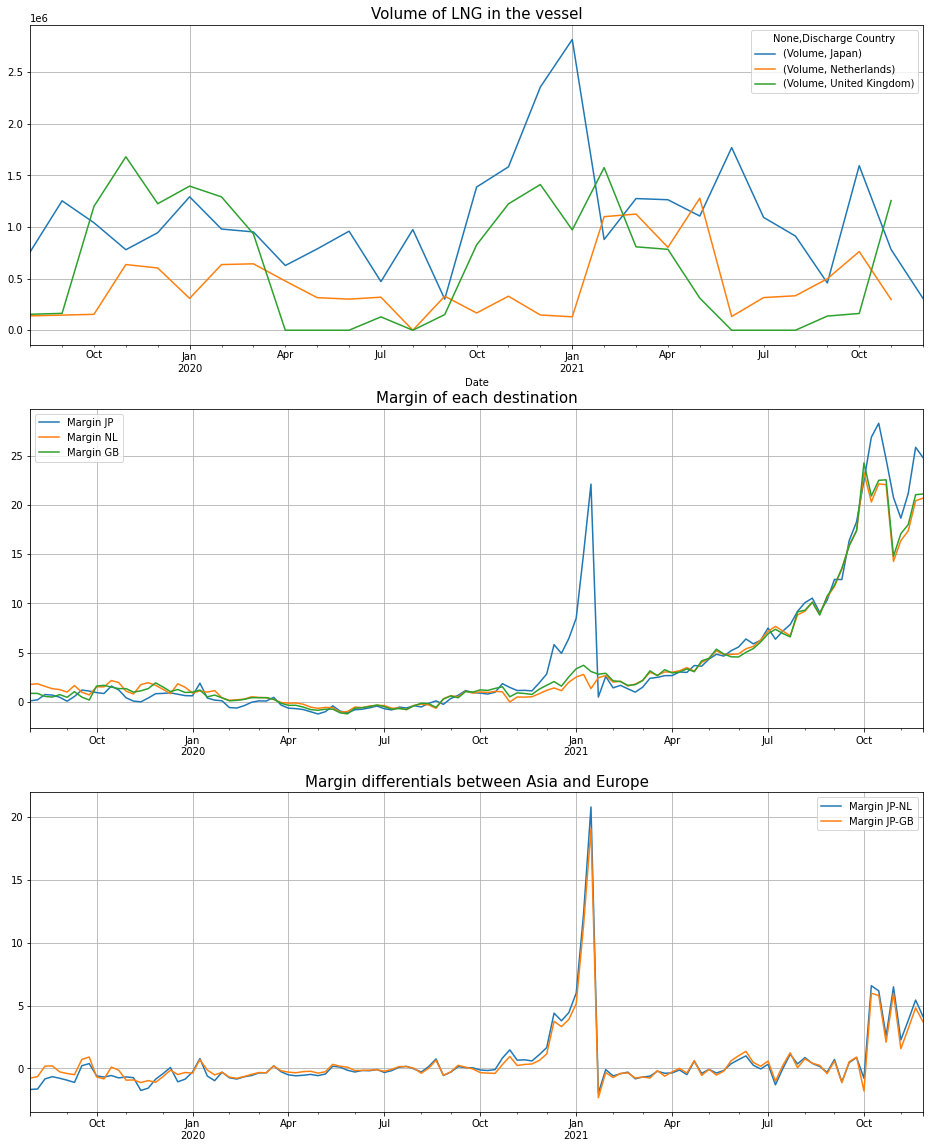

In [7]:
plt.rcParams["figure.figsize"] = (16,20)
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.set_title('Volume of LNG in the vessel', fontdict={'fontsize': 15, 'fontweight': 'medium'})
df_flows.groupby('Discharge Country').resample('M').sum().unstack(level=0).plot(ax=ax1)

df_plot = df[:max(df_flows.index).strftime("%Y-%m-01")]

ax2.set_title('Margin of each destination', fontdict={'fontsize': 15, 'fontweight': 'medium'})
df_plot[['Margin JP','Margin NL','Margin GB']].plot(ax=ax2)

ax3.set_title('Margin differentials between Asia and Europe'
              , fontdict={'fontsize': 15, 'fontweight': 'medium'})
df_plot[['Margin JP-NL','Margin JP-GB']].plot(ax=ax3)

ax1.grid()
ax2.grid()
ax3.grid()

plt.show()